In [35]:
import os 
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import pearsonr
from matplotlib.colors import LinearSegmentedColormap

In [54]:
INVENTORY, POLLUTION, BAY, PARKS = None, None, None, None
PARENT_DIR = os.getcwd()

In [37]:
def get_sites():
    global INVENTORY
    if INVENTORY is None:
        inventory = gpd.read_file(
            PARENT_DIR + "/data/housing_sites/xn--Bay_Area_Housing_Opportunity_Sites_Inventory__20072023_-it38a.shp"
        )
        INVENTORY = inventory.to_crs(epsg=3857)
    return INVENTORY

In [58]:
def get_parks():
    global PARKS
    if PARKS is None:
        parks = gpd.read_file(
            PARENT_DIR + "/data/CFF_SPP_Round4_Data/CFF_Update_2021_04_30/parks_final_2021_04_30.shp"
        )
        PARKS = parks.to_crs(epsg=3857)
    return PARKS

In [59]:
get_parks()

,holding_id,access_typ,unit_id,unit_name,suid_nma,agncy_id,agncy_name,agncy_lev,agncy_typ,agncy_web,...,yr_protect,yr_est,rec_cdpr,rec_lacnty,notes,operator,cpad_relea,cdpr_notes,lacnty_not,geometry
0,22264,Open Access,5793,Santa Rosa and San Jacinto Mountains National ...,4018,3025,Friends of the Desert Mountains,Non Profit,Non Profit - Land Trust,http://www.desertmountains.org/,...,0.0,2000.0,Same as CPAD,Same as CPAD,Coachella Valley Association of Governments; B...,GRC,Include,None,None,"POLYGON ((-12941870.528 3965284.602, -12941389..."
1,35773,Open Access,16727,Sierra National Forest,14137,107,United States Forest Service,Federal,Federal Agency,http://www.fs.fed.us/,...,0.0,1893.0,Same as CPAD,Same as CPAD,USFS data 2009; JJ,JJ,Include,None,None,"POLYGON ((-13239408.602 4479603.986, -13239434..."
2,55682,Open Access,23051,Modoc National Forest,14086,107,United States Forest Service,Federal,Federal Agency,http://www.fs.fed.us/,...,0.0,1904.0,Same as CPAD,Same as CPAD,Lake or pond; USFS data 2009; JJ 2008-09-09,JJ,Include,None,None,"POLYGON ((-13496754.886 5143462.165, -13496758..."
3,106862,Open Access,5449,Klamath National Forest,14043,107,United States Forest Service,Federal,Federal Agency,http://www.fs.fed.us/,...,0.0,1905.0,Same as CPAD,Same as CPAD,None,SG,Include,None,None,"POLYGON ((-13677454.340 5042483.269, -13677498..."
4,112040,Open Access,3805,Unnamed site - Coachella Valley Mountains Cons...,33333,214,Coachella Valley Mountains Conservancy,State,State Agency,http://www.cvmc.ca.gov/,...,0.0,0.0,Same as CPAD,Same as CPAD,"Adding new parcels, 2019 KB;",KB,Include,None,None,"POLYGON ((-12952651.075 4002232.561, -12952697..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66952,79967,Open Access,2856,Kessler Park,20635,318,"San Bernardino, County of",County,County Agency,http://cms.sbcounty.gov/parks/Home.aspx,...,0.0,0.0,Same as CPAD,Same as CPAD,County of San Bernardino parcel data 2011; LD,AR,Include,None,None,"POLYGON ((-13069003.192 4035131.472, -13069020..."
66953,15107,Open Access,2856,Kessler Park,20635,318,"San Bernardino, County of",County,County Agency,http://cms.sbcounty.gov/parks/Home.aspx,...,0.0,0.0,Same as CPAD,Same as CPAD,County of San Bernardino parcel data 2011; LD,AR,Include,None,None,"POLYGON ((-13069069.166 4035271.943, -13069069..."
66954,79968,Open Access,2856,Kessler Park,20635,318,"San Bernardino, County of",County,County Agency,http://cms.sbcounty.gov/parks/Home.aspx,...,0.0,0.0,Same as CPAD,Same as CPAD,County of San Bernardino parcel data 2011; LD,AR,Include,None,None,"POLYGON ((-13069260.373 4035075.913, -13069260..."
66955,79970,Open Access,2856,Kessler Park,20635,318,"San Bernardino, County of",County,County Agency,http://cms.sbcounty.gov/parks/Home.aspx,...,0.0,0.0,Same as CPAD,Same as CPAD,County of San Bernardino parcel data 2011; LD,AR,Include,None,None,"POLYGON ((-13069068.906 4035061.463, -13069069..."


In [38]:
def get_pollution_map():
    global POLLUTION
    if POLLUTION is None:
        pollution = gpd.read_file(
            './data/CalEnviroScreen_4.0Shapefile_D1_2021.shp'
        )
        POLLUTION = pollution.to_crs(epsg=3857)
    return POLLUTION

In [39]:
def get_bay_map():
    global BAY
    if BAY is None:
        bay = gpd.read_file(
            './data/bay_area_map/bay.shp'
        )
        bay['city'] = bay['city'].str.title()
        bay['county'] = bay['county'].str.title()
        BAY = bay.to_crs(epsg=3857)
    return BAY

In [40]:
def get_sites_for(city):
    sites = get_sites().query(f'jurisdict == "{city}"')
    return clean_real_cap(city, sites)

In [41]:
def get_5th_cycle_sites_for(city):
    return get_sites_for(city).query('rhnacyc == "RHNA5"')

In [42]:
def get_4th_cycle_sites_for(city):
    return get_sites_for(city).query('rhnacyc == "RHNA4"')

In [43]:
def get_city_sites_for_cycle(city, cycle):
    assert cycle in [4, 5]
    if cycle == 4:
        return get_4th_cycle_sites_for(city)
    else:
        return get_5th_cycle_sites_for(city)

In [44]:
def get_cities():
    cities_sites = set(get_sites().jurisdict.unique())
    cities_mapped = set(get_bay_map().city.unique())
    #cities_pollution = set(get_pollution_map().City.unique())
    cities = cities_sites.intersection(cities_mapped)
    cities = list(cities)
    cities.sort()
    return cities

In [45]:
def get_pollution_for(city):
    city_shape = get_bay_map().query(f'city == "{city}"')
    city_shape = city_shape[['city', 'geometry']]
    result = gpd.overlay(city_shape, get_pollution_map(), how='intersection', keep_geom_type=False)
    if result.size:
        return result
    return

In [46]:
"""Code lifted from project here: https://github.com/YIMBYdata/housing-elements/blob/main/housing_elements/data_loading_utils.py"""

def clean_real_cap(city, sites):
    sites = sites.copy()
    if city in ('Oakland', 'Los Altos Hills', 'Napa County', 'Newark'):
        sites = remove_range_in_realcap(sites)
    if city in ('Danville', 'San Ramon', 'Corte Madera', 'Portola Valley'):
        sites = remove_units_in_realcap(sites)
    if city == 'El Cerrito':
        sites = fix_el_cerrito_realcap(sites)
    sites['relcapcty'] = pd.to_numeric(sites['relcapcty'], errors='coerce')
    sites = sites.rename({'relcapcty': 'realcap'}, axis=1)
    return sites

def remove_range_in_realcap(sites: pd.DataFrame) -> pd.DataFrame:
    # E.g. Oakland, Newark
    sites.relcapcty = sites.relcapcty.str.split('-').str[-1]
    # Los Altos Hills
    sites.relcapcty = sites.relcapcty.str.split(' to ').str[-1]
    return sites

def remove_units_in_realcap(sites: pd.DataFrame) -> pd.DataFrame:
    # San Ramon
    sites.relcapcty = sites.relcapcty.str.replace('á', '', regex=False)
    # Danville
    sites.relcapcty = sites.relcapcty.str.replace('sfr', '', regex=False)
    sites.relcapcty = sites.relcapcty.str.replace('SFR', '', regex=False)
    sites.relcapcty = sites.relcapcty.str.replace('mfr', '', regex=False)
    # Danville, Corte Madera, Portola Valley
    sites.relcapcty = sites.relcapcty.str.split(' ').str[0]
    return sites

def fix_el_cerrito_realcap(sites: pd.DataFrame) -> pd.DataFrame:
    """El Cerrito's realcap is in plain english, listing primary units and accessory units."""
    el_cerrito_rc = []
    for v in sites.relcapcty.values:
        # If realcap includes primary and accessory units
        if isinstance(v, str) and 'primary and' in v:
            # Then let realcap equal double the # of primary units (which is always true)
            v = int(v.split(' ')[0]) * 2
        el_cerrito_rc.append(v)
    sites.relcapcty = el_cerrito_rc
    sites.relcapcty = sites.relcapcty.str.split(' ').str[0]
    return sites

To do: Check that geometry changes after intsection for at least one of the cities that pop up in print_pollution_map_city_incorrect()

In [47]:
def print_pollution_map_city_incorrect():
    """This function shows that census tracts extend beyond a single city."""
    for city in get_cities():
        n_tracts_trivial = sum(get_pollution_map().City == city)
        n_tracts_nontrivial = get_tracts(city).shape[0]
        if n_tracts_trivial != n_tracts_nontrivial:
            print(city, n_tracts_nontrivial - n_tracts_trivial)

In [48]:
def get_production_by_tract(tracts, sites):
    joined = gpd.tools.sjoin(tracts, sites)
    production_by_tract = joined.groupby('Tract').agg({'realcap': sum})
    return production_by_tract

In [49]:
def get_5th_cycle_tracts(city):
    sites = get_5th_cycle_sites_for(city)
    pollution = get_pollution_for(city)
    sites_by_tract = get_production_by_tract(pollution, sites)
    tracts = pollution.set_index('Tract')
    tracts['realcap'] = 0
    tracts.loc[sites_by_tract.index, 'realcap'] = sites_by_tract['realcap']
    tracts['acres'] = tracts['geometry'].to_crs(5070).geometry.area / 10**6 * 247
    tracts['homes per acre'] = tracts['realcap'] / tracts['acres']
    return tracts

In [50]:
tracts_SF = get_5th_cycle_tracts('San Francisco')

In [53]:
tracts_SF.Traffic

Tract
6.075980e+09     641.670538
6.075981e+09    1655.095661
6.075980e+09    1094.336016
6.075020e+09     488.941577
6.075013e+09     805.001329
                   ...     
6.075023e+09     336.374402
6.075018e+09    9621.617211
6.075023e+09     356.635284
6.075981e+09     282.201451
6.075023e+09     340.974151
Name: Traffic, Length: 202, dtype: float64

In [52]:
tracts_SF.columns

Index(['city', 'Population', 'CIscore', 'CIscoreP', 'Ozone', 'Ozone_Pctl',
       'PM2_5', 'PM2_5_Pctl', 'Diesel_PM', 'Diesel_PM_', 'Pesticides',
       'Pesticid_1', 'Tox_Releas', 'Tox_Rele_1', 'Traffic', 'Traffic_Pc',
       'Drinking_W', 'Drinking_1', 'Lead', 'Lead_Pctl', 'Cleanups',
       'Cleanups_P', 'Groundwate', 'Groundwa_1', 'Haz_Waste', 'Haz_Waste_',
       'Imp_Water_', 'Imp_Water1', 'Solid_Wast', 'Solid_Wa_1', 'PollutionS',
       'Pollution_', 'Asthma', 'Asthma_Pct', 'Low_Birth_', 'Low_Birth1',
       'Cardiovasc', 'Cardiova_1', 'Education', 'Education_', 'Linguistic',
       'Linguist_1', 'Poverty', 'Poverty_Pc', 'Unemployme', 'Unemploy_1',
       'Housing_Bu', 'Housing__1', 'PopCharSco', 'Pop_Char_P', 'County', 'ZIP',
       'City', 'Pctl_Range', 'Total_Pop_', 'Children_U', 'Pop_10_64_',
       'Edlerly_65', 'Hispanic', 'White', 'African_Am', 'Native_Ame',
       'Asian_Amer', 'Pacific_Is', 'Other_Mult', 'Shape_Leng', 'Shape_Area',
       'geometry', 'realcap', 'acres',

Text(0.5, 1.0, 'Are more homes planned for areas with more pollution?')

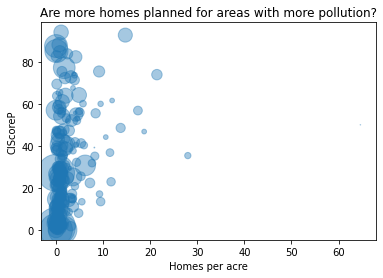

In [21]:
plt.scatter(tracts_SF['homes per acre'], tracts_SF['CIscoreP'], s=tracts_SF['acres'], alpha=.4)
plt.xlabel("Homes per acre")
plt.ylabel("CIScoreP")
plt.title('Are more homes planned for areas with more pollution?')

In [22]:
realcap_by_pctl = tracts_SF.groupby('Pctl_Range').agg({'realcap': sum})
realcap_by_pctl.sort_index(axis=0, key=lambda x: [int(v[0]) for v in x.str.split('-')], inplace=True)

In [23]:
realcap_by_pctl

,realcap
Pctl_Range,
1-5% (lowest scores),1791.0
6-10%,1205.0
11-15%,3180.0
16-20%,1549.0
21-25%,2759.0
26-30%,1453.0
31-35%,940.0
36-40%,1481.0
41-45%,1285.0


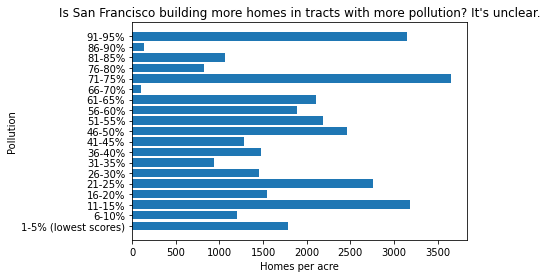

In [24]:
plt.barh(realcap_by_pctl.index, realcap_by_pctl.realcap)
plt.xlabel("Homes per acre")
plt.ylabel("Pollution")
plt.title("Is San Francisco building more homes in tracts with more pollution? It's unclear.")
plt.show()

In [27]:
def score_correlation(city, cycle):
    assert cycle in [4, 5]
    if cycle == 4:
        tracts = get_4th_cycle_tracts('Los Altos')
    else:
        tracts = get_5th_cycle_tracts('Los Altos')
    return pearsonr(tracts['homes per acre'], tracts['CIscoreP'])

In [28]:
score_correlation('Los Altos', 5)

(-0.25365054665247044, 0.2672296403173574)

In [29]:
def plot_pollution_map(city):
    pollution = get_pollution_for(city)
    fig, ax = plt.subplots(figsize=(15, 15))
    plt.rcParams.update({'font.size': 25})
    pollution.plot(ax=ax, column=pollution['CIscoreP'], legend=True, cmap=get_pastel_cmap())
    plt.rcParams.update({'font.size': 10})
    ax.set_yticklabels([])
    ax.set_xticklabels([])

In [30]:
def plot_sites_on_top_of_pollution_map(city, cycle):
    pollution = get_pollution_for(city)
    fig, ax = plt.subplots(figsize=(15, 15))
    plt.rcParams.update({'font.size': 25})
    pollution.plot(ax=ax, column=pollution['CIscoreP'], legend=True, cmap=get_pastel_cmap())
    plt.rcParams.update({'font.size': 10})
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    sites = get_city_sites_for_cycle(city, cycle)
    sites.plot(ax=ax, marker='o', markersize=100, color='steelblue')


In [31]:
def get_pastel_cmap():
    return LinearSegmentedColormap.from_list('pastel', [('#9EFF9E'), ('#ff6961')])

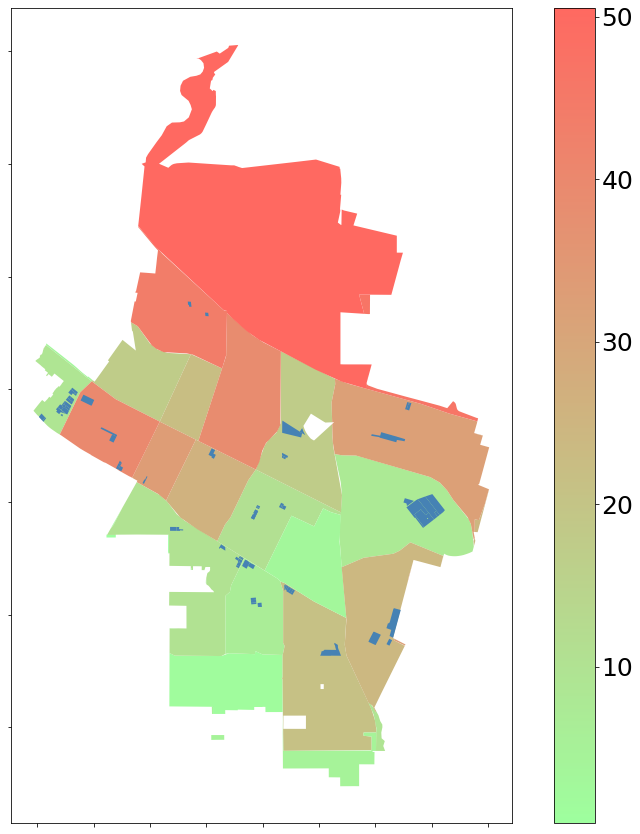

In [32]:
plot_sites_on_top_of_pollution_map('Mountain View', 5)

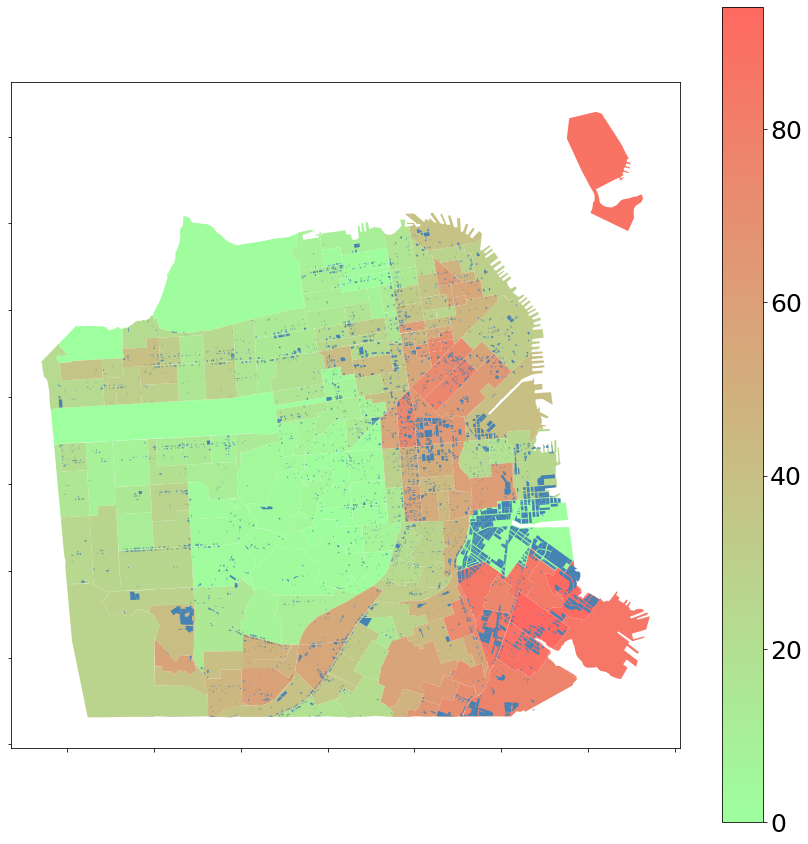

In [33]:
plot_sites_on_top_of_pollution_map('San Francisco', 5)

In [34]:
get_5th_cycle_sites_for('San Francisco').columns

Index(['objectid', 'rhnacyc', 'rhnayrs', 'county', 'jurisdict', 'apn',
       'locapn', 'genplan', 'zoning', 'gacres', 'locacres', 'currunits',
       'allowden', 'allowlow', 'allowhigh', 'realcap', 'desafford', 'aff_vl',
       'aff_l', 'aff_m', 'aff_am', 'num_vl', 'num_l', 'num_m', 'num_am',
       'infcapcty', 'siteconst', 'sitetype', 'pdaparcel', 'bundled',
       'existuse', 'localnote', 'Shape__Are', 'Shape__Len', 'geometry'],
      dtype='object')

In [353]:
get_5th_cycle_sites_for('San Francisco').allowden.value_counts()

0               884
16.206051518      4
22.776500043      2
11.493562         2
20.424166484      2
               ... 
20.951187395      1
13.925551726      1
214.31905477      1
14.929365847      1
10.961940536      1
Name: allowden, Length: 3817, dtype: int64